In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from sklearn import model_selection
from sklearn import metrics
!pip install bert-for-tf2
import bert
from bert import bert_tokenization
import os

### BERT ENCODE FUNCTON:
    Splits the text into tokens and converts tokens into Ids. This function returns three arrays: tokens, masks and segments

In [2]:
def bert_encode(texts, tokenizer, max_len=160):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

## Build Function:
    This function creates 3 layers for BERT model and the model is compiled with Adam optimizer and binary crossentropy as  the loss function.

In [3]:
def build_model_LSTM(bert_layer, max_len=160):
    embedding_size=768
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    bert_output_ = tf.keras.layers.Reshape((max_len, embedding_size))(sequence_output)
    LSTM_out= tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(bert_output_)

    dense = tf.keras.layers.Dense(256, activation="relu")(LSTM_out)
    pred = tf.keras.layers.Dense(1, activation="sigmoid")(dense)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pred)
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [4]:
def build_model_GRU(bert_layer, max_len=160):
    embedding_size=768
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    bert_output_ = tf.keras.layers.Reshape((max_len, embedding_size))(sequence_output)
    GRU_out= tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True))(bert_output_)

    dense = tf.keras.layers.Dense(256, activation="relu")(GRU_out)
    pred = tf.keras.layers.Dense(1, activation="sigmoid")(dense)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pred)
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

### Load BERT layer

In [5]:
%%time
#module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
module_url ="https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 25.2 s, sys: 6.77 s, total: 32 s
Wall time: 1min 2s


### Load dataset and split the dataset into training and test sets

In [6]:
dataset=pd.read_csv("politifact_content.csv",encoding='latin1')

In [7]:
train,test=model_selection.train_test_split(dataset,test_size=0.20)

### Encode the data using helper functions(bert_encode())

In [8]:

FullTokenizer = bert.bert_tokenization.FullTokenizer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

To reduce the training size, first 500 samples are used and test dataset size remains same

In [9]:
train_input = bert_encode(train['content'][0:500], tokenizer, max_len = 160)
test_input = bert_encode(test['content'], tokenizer, max_len = 160)
train_labels = train['label'][0:500]
test_labels = test['label']

### Building the model and training the model

In [10]:
model1 = build_model_LSTM(bert_layer, max_len = 160)
model1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [11]:
model2 = build_model_GRU(bert_layer, max_len = 160)
model2.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [12]:
history1 = model1.fit(
    train_input, train_labels,
    validation_split=0.1,
    epochs=5,
    batch_size=20
)

Epoch 1/5
15/15 [==============================] - 533s 36s/step - loss: 0.5939 - accuracy: 0.6826 - val_loss: 0.6420 - val_accuracy: 0.6004
Epoch 2/5
15/15 [==============================] - 518s 35s/step - loss: 0.4174 - accuracy: 0.8408 - val_loss: 0.4559 - val_accuracy: 0.7632
Epoch 3/5
15/15 [==============================] - 519s 35s/step - loss: 0.2486 - accuracy: 0.9292 - val_loss: 0.4580 - val_accuracy: 0.7697
Epoch 4/5
15/15 [==============================] - 519s 35s/step - loss: 0.1663 - accuracy: 0.9591 - val_loss: 0.4540 - val_accuracy: 0.7765
Epoch 5/5
15/15 [==============================] - 519s 35s/step - loss: 0.0887 - accuracy: 0.9772 - val_loss: 0.5025 - val_accuracy: 0.7706


In [13]:
history2 = model2.fit(
    train_input, train_labels,
    validation_split=0.1,
    epochs=5,
    batch_size=20
)

Epoch 1/5
15/15 [==============================] - 516s 34s/step - loss: 0.1764 - accuracy: 0.9339 - val_loss: 0.7447 - val_accuracy: 0.7840
Epoch 2/5
15/15 [==============================] - 516s 34s/step - loss: 0.1107 - accuracy: 0.9608 - val_loss: 0.8131 - val_accuracy: 0.7903
Epoch 3/5
15/15 [==============================] - 515s 34s/step - loss: 0.0507 - accuracy: 0.9809 - val_loss: 0.9811 - val_accuracy: 0.7643
Epoch 4/5
15/15 [==============================] - 515s 34s/step - loss: 0.0348 - accuracy: 0.9915 - val_loss: 0.6483 - val_accuracy: 0.7833
Epoch 5/5
15/15 [==============================] - 517s 34s/step - loss: 0.0249 - accuracy: 0.9966 - val_loss: 0.6520 - val_accuracy: 0.7831


In [14]:
model1.save('bert_model_LSTM.h5')
model2.save('bert_model_GRU.h5')

In [15]:
test_pred = model1.predict(test_input)
test_pred = test_pred.round().astype(int)
print(test_pred)

test_pred = model2.predict(test_input)
test_pred = test_pred.round().astype(int)
print(test_pred)

[[[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 ...

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]]
[[[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 ...

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]]


{'loss': [0.5939096808433533, 0.4174410104751587, 0.24855747818946838, 0.16634654998779297, 0.08865689486265182], 'accuracy': [0.6825713515281677, 0.8408137559890747, 0.9291946291923523, 0.9591023325920105, 0.9772231578826904], 'val_loss': [0.6419996023178101, 0.4559127986431122, 0.45798665285110474, 0.4540223479270935, 0.5024527907371521], 'val_accuracy': [0.6003676056861877, 0.763235330581665, 0.7696691155433655, 0.7764706015586853, 0.7705882787704468]}


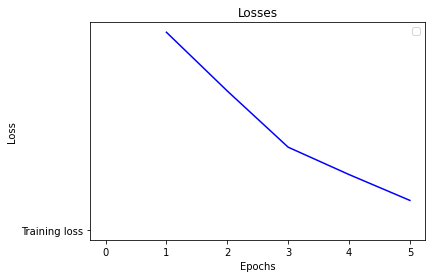

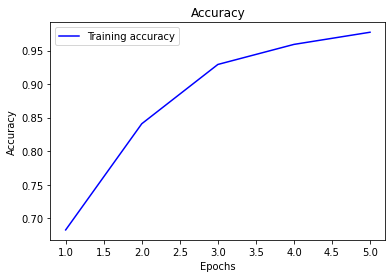

In [16]:
history_dict=history1.history
print(history_dict)

#Training and validation
import matplotlib.pyplot as plt
loss_values   = history_dict['loss']
acc_values   = history_dict['accuracy']

epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, loss_values, 'b', 'Training loss')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()

plt.plot(epochs, acc_values, 'b', label='Training accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

{'loss': [0.17635124921798706, 0.11070657521486282, 0.05068656802177429, 0.0348232127726078, 0.0248978640884161], 'accuracy': [0.9338715672492981, 0.9607592225074768, 0.9808515310287476, 0.9914848804473877, 0.9966443181037903], 'val_loss': [0.7446960806846619, 0.8131088018417358, 0.9810614585876465, 0.6482692360877991, 0.6519763469696045], 'val_accuracy': [0.7840073704719543, 0.7902573347091675, 0.7643381953239441, 0.7832720875740051, 0.783088207244873]}


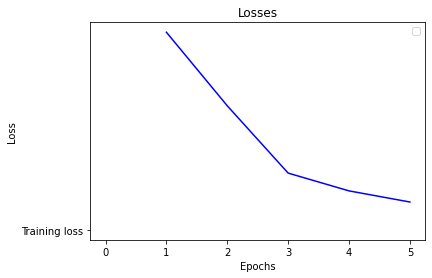

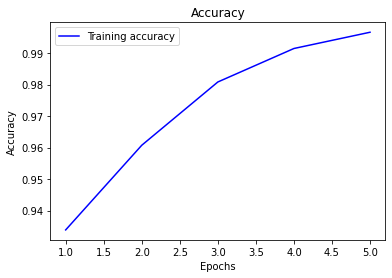

In [17]:
history_dict=history2.history
print(history_dict)

#Training and validation
import matplotlib.pyplot as plt
loss_values   = history_dict['loss']
acc_values   = history_dict['accuracy']

epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, loss_values, 'b', 'Training loss')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()

plt.plot(epochs, acc_values, 'b', label='Training accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()